In [1]:
# Choose which feature to predict:
features_out = ["prod_wind", "prod_solar"]

In [16]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython
import IPython.display


sns.set_theme()

ModuleNotFoundError: No module named 'tensorflow_addons'

In [4]:
df = pd.read_pickle("..\data\data_prepared.pkl")
df.head()

,prod_wind,prod_solar,day_sin,day_cos,year_sin,year_cos,solar_el,solar_el_clip
datetime,,,,,,,,
2020-01-01 00:00:00+00:00,6989.50,0.0,-7.670342e-12,1.000000,-2.150345e-03,0.999998,-60.949049,0.0
2020-01-01 01:00:00+00:00,7371.25,0.0,2.588190e-01,0.965926,-1.433564e-03,0.999999,-56.073363,0.0
2020-01-01 02:00:00+00:00,7447.75,0.0,5.000000e-01,0.866025,-7.167823e-04,1.000000,-48.553549,0.0
2020-01-01 03:00:00+00:00,7699.25,0.0,7.071068e-01,0.707107,1.964387e-15,1.000000,-39.725411,0.0
2020-01-01 04:00:00+00:00,7703.00,0.0,8.660254e-01,0.500000,7.167823e-04,1.000000,-30.389395,0.0


In [5]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]

num_features = len(features_out)

In [6]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
# fit scaler to training data
scaler.fit(df_train)
# scale all sets according to train set, preserve data frames
df_train = pd.DataFrame(scaler.transform(df_train),
                        columns=df.columns, index=df_train.index)
df_val = pd.DataFrame(scaler.transform(df_val),
                        columns=df.columns, index=df_val.index)
df_test = pd.DataFrame(scaler.transform(df_test),
                        columns=df.columns, index=df_test.index)

In [7]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=df_train, val_df=df_val, test_df=df_test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [8]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [9]:
def plot(self, model=None, plot_col="prod_solar", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=3)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        # Add last point of input array to label and prediction arrays to connect lines
        label_indices_plot = np.insert(
            self.label_indices, 0, self.input_indices[-1])
        labels_plot = np.insert(
            labels[n, :, label_col_index], 0, inputs[n, :, plot_col_index][-1])

        plt.plot(label_indices_plot, labels_plot, 'C2',
                 label='Labels', marker='.', zorder=1)
        if model is not None:
            predictions_plot = (model(inputs))[n, :, label_col_index]
            predictions_plot = np.insert(
                predictions_plot, 0, inputs[n, :, plot_col_index][-1])
            plt.plot(label_indices_plot, predictions_plot,
                     'C1', label='Predictions', marker='.', zorder=2)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')


WindowGenerator.plot = plot

In [10]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [11]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.test` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['prod_wind', 'prod_solar']

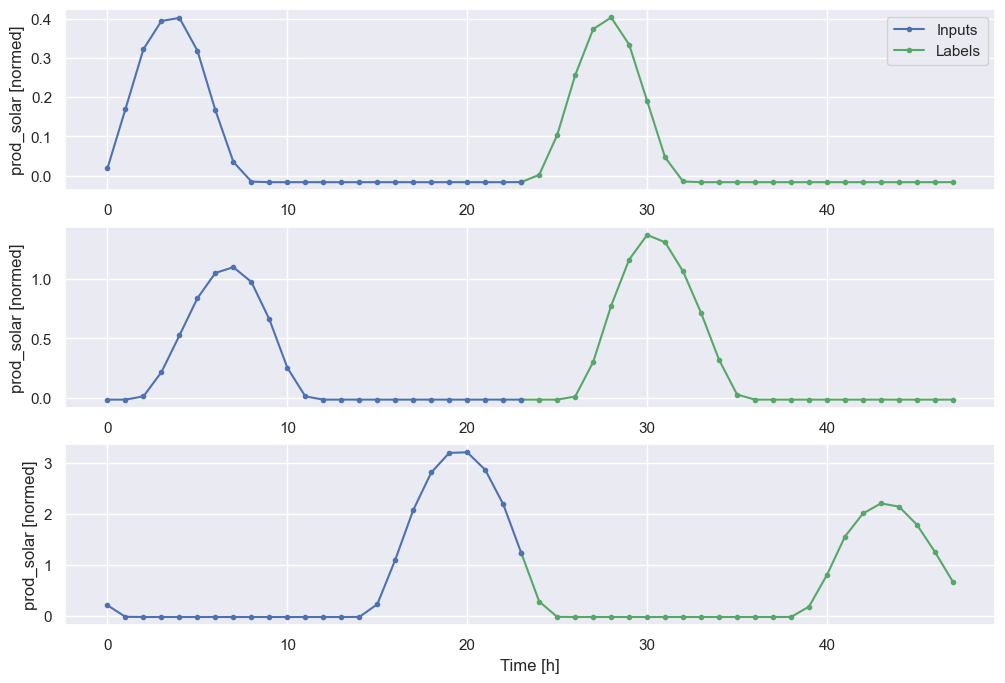

In [12]:
IN_STEPS = 24
OUT_STEPS = 24

multi_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=IN_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=features_out)

multi_window.plot()
multi_window

In [14]:
MAX_EPOCHS = 5


def compile_and_fit(model, window, patience=4):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      verbose=1)

    model.compile(loss='mse', optimizer='adam', metrics=['mae', RSquare()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [19]:
def build_model(params):
    lstm_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(params['n_unit'], return_sequences=False),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features].
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
    return lstm_model

109/109 [==============================] - 0s 2ms/step - loss: 0.1014 - mae: 0.2159 - r_square: 0.7114


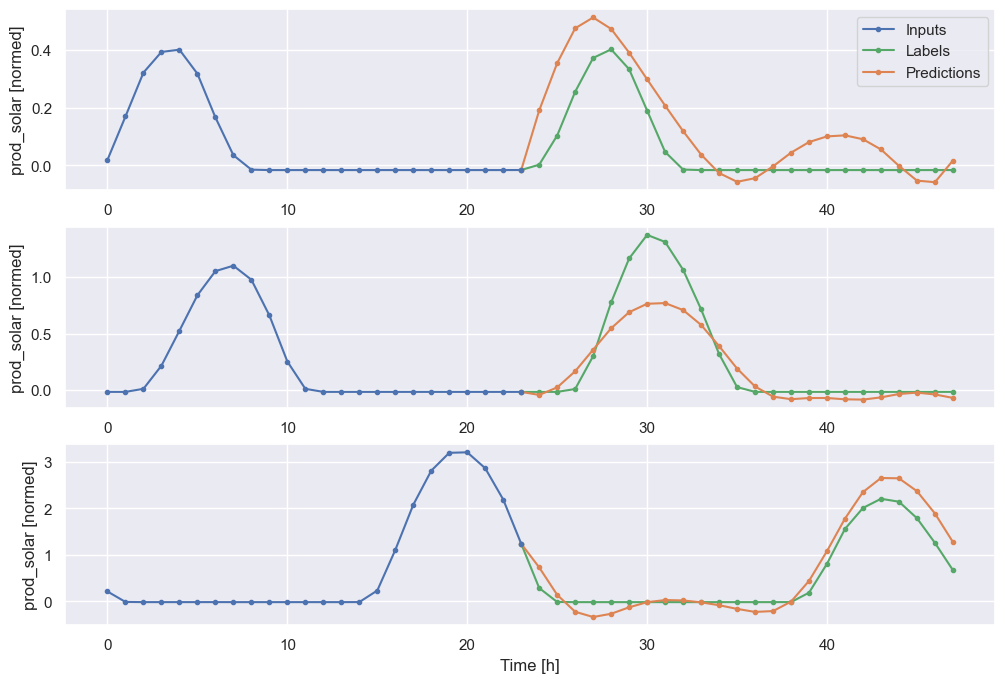

In [18]:
from tensorflow_addons.metrics.r_square import RSquare
lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(lstm_model, multi_window)

IPython.display.clear_output()

val_performance = {}
test_performance = {}

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
test_performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(lstm_model)

In [ ]:
import optuna as optuna
def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'n_unit': trial.suggest_int("n_unit", 4, 18)
              }
    
    model = build_model(params)
    history = compile_and_fit(model, multi_window)
    
    accuracy = lstm_model.evaluate(multi_window.test, verbose=0)

    return accuracy[1]

In [22]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

[I 2022-10-12 01:43:55,135] A new study created in memory with name: no-name-16894d8f-f0f4-44e1-b057-69d70c5a3881
C:\Users\Dilara\AppData\Local\Temp\ipykernel_23228\2551197893.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


Epoch 1/25
383/383 [==============================] - 5s 8ms/step - loss: 0.3186 - mae: 0.4061 - r_square: 0.5181 - val_loss: 0.1645 - val_mae: 0.3009 - val_r_square: 0.6431
Epoch 2/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1505 - mae: 0.2832 - r_square: 0.7324 - val_loss: 0.1155 - val_mae: 0.2382 - val_r_square: 0.6940
Epoch 3/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1331 - mae: 0.2557 - r_square: 0.7567 - val_loss: 0.1074 - val_mae: 0.2259 - val_r_square: 0.7082
Epoch 4/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1270 - mae: 0.2469 - r_square: 0.7668 - val_loss: 0.1025 - val_mae: 0.2189 - val_r_square: 0.7181
Epoch 5/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1233 - mae: 0.2417 - r_square: 0.7732 - val_loss: 0.1005 - val_mae: 0.2137 - val_r_square: 0.7231
Epoch 6/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1204 - mae: 0.2378 - r_square: 0.7781 - val_loss: 0.10

[W 2022-10-12 01:44:39,533] Trial 0 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 5s 8ms/step - loss: 0.3095 - mae: 0.4017 - r_square: 0.5284 - val_loss: 0.1583 - val_mae: 0.2952 - val_r_square: 0.6525
Epoch 2/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1507 - mae: 0.2840 - r_square: 0.7318 - val_loss: 0.1182 - val_mae: 0.2385 - val_r_square: 0.6951
Epoch 3/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1343 - mae: 0.2575 - r_square: 0.7553 - val_loss: 0.1122 - val_mae: 0.2347 - val_r_square: 0.7043
Epoch 4/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1278 - mae: 0.2479 - r_square: 0.7660 - val_loss: 0.1044 - val_mae: 0.2242 - val_r_square: 0.7180
Epoch 5/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1234 - mae: 0.2419 - r_square: 0.7733 - val_loss: 0.1018 - val_mae: 0.2194 - val_r_square: 0.7209
Epoch 6/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1208 - mae: 0.2381 - r_square: 0.7780 - val_loss: 0.09

[W 2022-10-12 01:45:17,861] Trial 1 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 5s 8ms/step - loss: 0.3116 - mae: 0.4043 - r_square: 0.5270 - val_loss: 0.1790 - val_mae: 0.3200 - val_r_square: 0.6368
Epoch 2/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1555 - mae: 0.2904 - r_square: 0.7286 - val_loss: 0.1199 - val_mae: 0.2462 - val_r_square: 0.6920
Epoch 3/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1330 - mae: 0.2557 - r_square: 0.7585 - val_loss: 0.1134 - val_mae: 0.2312 - val_r_square: 0.7116
Epoch 4/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1263 - mae: 0.2460 - r_square: 0.7692 - val_loss: 0.1153 - val_mae: 0.2337 - val_r_square: 0.7121
Epoch 5/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1228 - mae: 0.2410 - r_square: 0.7752 - val_loss: 0.1065 - val_mae: 0.2199 - val_r_square: 0.7229
Epoch 6/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1194 - mae: 0.2365 - r_square: 0.7806 - val_loss: 0.10

[W 2022-10-12 01:45:54,069] Trial 2 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 5s 8ms/step - loss: 0.3118 - mae: 0.4031 - r_square: 0.5272 - val_loss: 0.1694 - val_mae: 0.3099 - val_r_square: 0.6375
Epoch 2/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1526 - mae: 0.2864 - r_square: 0.7303 - val_loss: 0.1174 - val_mae: 0.2434 - val_r_square: 0.6936
Epoch 3/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1343 - mae: 0.2573 - r_square: 0.7556 - val_loss: 0.1139 - val_mae: 0.2372 - val_r_square: 0.7023
Epoch 4/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1277 - mae: 0.2475 - r_square: 0.7661 - val_loss: 0.1040 - val_mae: 0.2225 - val_r_square: 0.7204
Epoch 5/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1230 - mae: 0.2413 - r_square: 0.7738 - val_loss: 0.0998 - val_mae: 0.2189 - val_r_square: 0.7218
Epoch 6/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1199 - mae: 0.2371 - r_square: 0.7792 - val_loss: 0.09

[W 2022-10-12 01:46:37,639] Trial 3 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 6s 9ms/step - loss: 0.3151 - mae: 0.4060 - r_square: 0.5249 - val_loss: 0.1735 - val_mae: 0.3152 - val_r_square: 0.6357
Epoch 2/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1535 - mae: 0.2889 - r_square: 0.7303 - val_loss: 0.1199 - val_mae: 0.2458 - val_r_square: 0.6926
Epoch 3/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1335 - mae: 0.2566 - r_square: 0.7569 - val_loss: 0.1096 - val_mae: 0.2296 - val_r_square: 0.7069
Epoch 4/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1276 - mae: 0.2475 - r_square: 0.7665 - val_loss: 0.1044 - val_mae: 0.2227 - val_r_square: 0.7160
Epoch 5/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1233 - mae: 0.2414 - r_square: 0.7739 - val_loss: 0.1014 - val_mae: 0.2160 - val_r_square: 0.7230
Epoch 6/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1199 - mae: 0.2370 - r_square: 0.7795 - val_loss: 0.10

[W 2022-10-12 01:47:24,759] Trial 4 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 5s 9ms/step - loss: 0.2973 - mae: 0.3936 - r_square: 0.5417 - val_loss: 0.1505 - val_mae: 0.2877 - val_r_square: 0.6486
Epoch 2/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1470 - mae: 0.2778 - r_square: 0.7365 - val_loss: 0.1161 - val_mae: 0.2379 - val_r_square: 0.6927
Epoch 3/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1317 - mae: 0.2533 - r_square: 0.7595 - val_loss: 0.1111 - val_mae: 0.2347 - val_r_square: 0.7011
Epoch 4/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1251 - mae: 0.2440 - r_square: 0.7706 - val_loss: 0.1073 - val_mae: 0.2257 - val_r_square: 0.7141
Epoch 5/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1207 - mae: 0.2383 - r_square: 0.7781 - val_loss: 0.1032 - val_mae: 0.2217 - val_r_square: 0.7192
Epoch 6/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1178 - mae: 0.2345 - r_square: 0.7830 - val_loss: 0.10

[W 2022-10-12 01:48:01,774] Trial 5 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 6s 10ms/step - loss: 0.3132 - mae: 0.4045 - r_square: 0.5258 - val_loss: 0.1618 - val_mae: 0.3039 - val_r_square: 0.6397
Epoch 2/25
383/383 [==============================] - 3s 9ms/step - loss: 0.1498 - mae: 0.2820 - r_square: 0.7345 - val_loss: 0.1182 - val_mae: 0.2417 - val_r_square: 0.6891
Epoch 3/25
383/383 [==============================] - 3s 9ms/step - loss: 0.1325 - mae: 0.2545 - r_square: 0.7591 - val_loss: 0.1101 - val_mae: 0.2302 - val_r_square: 0.7085
Epoch 4/25
383/383 [==============================] - 3s 9ms/step - loss: 0.1268 - mae: 0.2461 - r_square: 0.7686 - val_loss: 0.1038 - val_mae: 0.2207 - val_r_square: 0.7192
Epoch 5/25
383/383 [==============================] - 3s 9ms/step - loss: 0.1227 - mae: 0.2405 - r_square: 0.7754 - val_loss: 0.1054 - val_mae: 0.2196 - val_r_square: 0.7206
Epoch 6/25
383/383 [==============================] - 3s 9ms/step - loss: 0.1193 - mae: 0.2360 - r_square: 0.7810 - val_loss: 0.1

[W 2022-10-12 01:48:48,892] Trial 6 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 6s 10ms/step - loss: 0.3218 - mae: 0.4089 - r_square: 0.5163 - val_loss: 0.1678 - val_mae: 0.3151 - val_r_square: 0.6215
Epoch 2/25
383/383 [==============================] - 3s 9ms/step - loss: 0.1508 - mae: 0.2829 - r_square: 0.7323 - val_loss: 0.1162 - val_mae: 0.2413 - val_r_square: 0.6912
Epoch 3/25
383/383 [==============================] - 3s 9ms/step - loss: 0.1332 - mae: 0.2553 - r_square: 0.7568 - val_loss: 0.1073 - val_mae: 0.2270 - val_r_square: 0.7111
Epoch 4/25
383/383 [==============================] - 3s 9ms/step - loss: 0.1272 - mae: 0.2464 - r_square: 0.7665 - val_loss: 0.1033 - val_mae: 0.2198 - val_r_square: 0.7183
Epoch 5/25
383/383 [==============================] - 3s 9ms/step - loss: 0.1228 - mae: 0.2407 - r_square: 0.7739 - val_loss: 0.0998 - val_mae: 0.2152 - val_r_square: 0.7239
Epoch 6/25
383/383 [==============================] - 3s 9ms/step - loss: 0.1201 - mae: 0.2371 - r_square: 0.7787 - val_loss: 0.0

[W 2022-10-12 01:49:59,337] Trial 7 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 5s 8ms/step - loss: 0.3196 - mae: 0.4073 - r_square: 0.5175 - val_loss: 0.1640 - val_mae: 0.3040 - val_r_square: 0.6423
Epoch 2/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1490 - mae: 0.2807 - r_square: 0.7343 - val_loss: 0.1162 - val_mae: 0.2389 - val_r_square: 0.6953
Epoch 3/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1324 - mae: 0.2548 - r_square: 0.7582 - val_loss: 0.1078 - val_mae: 0.2266 - val_r_square: 0.7068
Epoch 4/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1267 - mae: 0.2469 - r_square: 0.7677 - val_loss: 0.1122 - val_mae: 0.2281 - val_r_square: 0.7120
Epoch 5/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1230 - mae: 0.2417 - r_square: 0.7738 - val_loss: 0.1008 - val_mae: 0.2159 - val_r_square: 0.7219
Epoch 6/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1202 - mae: 0.2377 - r_square: 0.7787 - val_loss: 0.09

[W 2022-10-12 01:50:52,310] Trial 8 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 5s 8ms/step - loss: 0.3129 - mae: 0.4020 - r_square: 0.5203 - val_loss: 0.1600 - val_mae: 0.3044 - val_r_square: 0.6345
Epoch 2/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1510 - mae: 0.2836 - r_square: 0.7308 - val_loss: 0.1166 - val_mae: 0.2376 - val_r_square: 0.6999
Epoch 3/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1340 - mae: 0.2571 - r_square: 0.7556 - val_loss: 0.1064 - val_mae: 0.2234 - val_r_square: 0.7125
Epoch 4/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1278 - mae: 0.2481 - r_square: 0.7658 - val_loss: 0.1039 - val_mae: 0.2214 - val_r_square: 0.7166
Epoch 5/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1234 - mae: 0.2421 - r_square: 0.7732 - val_loss: 0.1012 - val_mae: 0.2163 - val_r_square: 0.7204
Epoch 6/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1205 - mae: 0.2382 - r_square: 0.7781 - val_loss: 0.10

[W 2022-10-12 01:51:39,361] Trial 9 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 6s 9ms/step - loss: 0.3160 - mae: 0.4027 - r_square: 0.5231 - val_loss: 0.1558 - val_mae: 0.2918 - val_r_square: 0.6496
Epoch 2/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1500 - mae: 0.2829 - r_square: 0.7332 - val_loss: 0.1145 - val_mae: 0.2367 - val_r_square: 0.6945
Epoch 3/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1336 - mae: 0.2560 - r_square: 0.7565 - val_loss: 0.1101 - val_mae: 0.2318 - val_r_square: 0.7042
Epoch 4/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1263 - mae: 0.2454 - r_square: 0.7680 - val_loss: 0.1039 - val_mae: 0.2230 - val_r_square: 0.7139
Epoch 5/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1226 - mae: 0.2404 - r_square: 0.7744 - val_loss: 0.1000 - val_mae: 0.2156 - val_r_square: 0.7235
Epoch 6/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1195 - mae: 0.2362 - r_square: 0.7797 - val_loss: 0.09

[W 2022-10-12 01:52:24,081] Trial 10 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 5s 9ms/step - loss: 0.3208 - mae: 0.4071 - r_square: 0.5169 - val_loss: 0.1639 - val_mae: 0.3056 - val_r_square: 0.6398
Epoch 2/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1486 - mae: 0.2802 - r_square: 0.7361 - val_loss: 0.1157 - val_mae: 0.2393 - val_r_square: 0.6980
Epoch 3/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1312 - mae: 0.2528 - r_square: 0.7607 - val_loss: 0.1068 - val_mae: 0.2273 - val_r_square: 0.7134
Epoch 4/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1250 - mae: 0.2441 - r_square: 0.7711 - val_loss: 0.1055 - val_mae: 0.2268 - val_r_square: 0.7132
Epoch 5/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1212 - mae: 0.2390 - r_square: 0.7775 - val_loss: 0.1034 - val_mae: 0.2243 - val_r_square: 0.7180
Epoch 6/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1182 - mae: 0.2349 - r_square: 0.7827 - val_loss: 0.10

[W 2022-10-12 01:53:10,710] Trial 11 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 5s 9ms/step - loss: 0.3175 - mae: 0.4070 - r_square: 0.5210 - val_loss: 0.1810 - val_mae: 0.3169 - val_r_square: 0.6280
Epoch 2/25
383/383 [==============================] - 498s 1s/step - loss: 0.1576 - mae: 0.2944 - r_square: 0.7237 - val_loss: 0.1213 - val_mae: 0.2467 - val_r_square: 0.6886
Epoch 3/25
383/383 [==============================] - 962s 3s/step - loss: 0.1358 - mae: 0.2596 - r_square: 0.7526 - val_loss: 0.1112 - val_mae: 0.2312 - val_r_square: 0.7005
Epoch 4/25
383/383 [==============================] - 32301s 85s/step - loss: 0.1285 - mae: 0.2484 - r_square: 0.7640 - val_loss: 0.1044 - val_mae: 0.2226 - val_r_square: 0.7152
Epoch 5/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1240 - mae: 0.2421 - r_square: 0.7717 - val_loss: 0.1054 - val_mae: 0.2226 - val_r_square: 0.7163
Epoch 6/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1208 - mae: 0.2379 - r_square: 0.7770 - val_loss

[W 2022-10-12 11:16:45,993] Trial 12 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 5s 8ms/step - loss: 0.3065 - mae: 0.3975 - r_square: 0.5343 - val_loss: 0.1566 - val_mae: 0.2926 - val_r_square: 0.6441
Epoch 2/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1460 - mae: 0.2766 - r_square: 0.7387 - val_loss: 0.1198 - val_mae: 0.2432 - val_r_square: 0.6844
Epoch 3/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1317 - mae: 0.2533 - r_square: 0.7594 - val_loss: 0.1142 - val_mae: 0.2314 - val_r_square: 0.7004
Epoch 4/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1255 - mae: 0.2447 - r_square: 0.7697 - val_loss: 0.1112 - val_mae: 0.2292 - val_r_square: 0.6993
Epoch 5/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1216 - mae: 0.2400 - r_square: 0.7763 - val_loss: 0.1058 - val_mae: 0.2175 - val_r_square: 0.7072
Epoch 6/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1185 - mae: 0.2357 - r_square: 0.7815 - val_loss: 0.10

[W 2022-10-12 11:17:27,811] Trial 13 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 6s 10ms/step - loss: 0.3218 - mae: 0.4099 - r_square: 0.5151 - val_loss: 0.1770 - val_mae: 0.3217 - val_r_square: 0.6324
Epoch 2/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1561 - mae: 0.2913 - r_square: 0.7270 - val_loss: 0.1169 - val_mae: 0.2379 - val_r_square: 0.6998
Epoch 3/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1338 - mae: 0.2564 - r_square: 0.7571 - val_loss: 0.1082 - val_mae: 0.2241 - val_r_square: 0.7111
Epoch 4/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1272 - mae: 0.2471 - r_square: 0.7678 - val_loss: 0.1046 - val_mae: 0.2187 - val_r_square: 0.7179
Epoch 5/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1228 - mae: 0.2413 - r_square: 0.7753 - val_loss: 0.1037 - val_mae: 0.2160 - val_r_square: 0.7165
Epoch 6/25
383/383 [==============================] - 3s 9ms/step - loss: 0.1199 - mae: 0.2372 - r_square: 0.7802 - val_loss: 0.1

[W 2022-10-12 11:18:23,664] Trial 14 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 5s 8ms/step - loss: 0.3153 - mae: 0.4062 - r_square: 0.5226 - val_loss: 0.1681 - val_mae: 0.3109 - val_r_square: 0.6341
Epoch 2/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1524 - mae: 0.2873 - r_square: 0.7310 - val_loss: 0.1206 - val_mae: 0.2461 - val_r_square: 0.6859
Epoch 3/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1331 - mae: 0.2555 - r_square: 0.7576 - val_loss: 0.1090 - val_mae: 0.2314 - val_r_square: 0.7064
Epoch 4/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1267 - mae: 0.2458 - r_square: 0.7679 - val_loss: 0.1079 - val_mae: 0.2296 - val_r_square: 0.7086
Epoch 5/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1224 - mae: 0.2398 - r_square: 0.7747 - val_loss: 0.1021 - val_mae: 0.2198 - val_r_square: 0.7203
Epoch 6/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1198 - mae: 0.2364 - r_square: 0.7794 - val_loss: 0.09

[W 2022-10-12 11:18:59,000] Trial 15 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 5s 9ms/step - loss: 0.3186 - mae: 0.4052 - r_square: 0.5212 - val_loss: 0.1670 - val_mae: 0.3117 - val_r_square: 0.6284
Epoch 2/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1512 - mae: 0.2843 - r_square: 0.7321 - val_loss: 0.1204 - val_mae: 0.2477 - val_r_square: 0.6897
Epoch 3/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1340 - mae: 0.2562 - r_square: 0.7561 - val_loss: 0.1096 - val_mae: 0.2305 - val_r_square: 0.7076
Epoch 4/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1275 - mae: 0.2470 - r_square: 0.7666 - val_loss: 0.1036 - val_mae: 0.2204 - val_r_square: 0.7219
Epoch 5/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1233 - mae: 0.2414 - r_square: 0.7736 - val_loss: 0.1008 - val_mae: 0.2187 - val_r_square: 0.7225
Epoch 6/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1197 - mae: 0.2367 - r_square: 0.7795 - val_loss: 0.10

[W 2022-10-12 11:19:37,446] Trial 16 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 5s 9ms/step - loss: 0.3228 - mae: 0.4091 - r_square: 0.5171 - val_loss: 0.1680 - val_mae: 0.3077 - val_r_square: 0.6400
Epoch 2/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1539 - mae: 0.2882 - r_square: 0.7287 - val_loss: 0.1190 - val_mae: 0.2440 - val_r_square: 0.6932
Epoch 3/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1339 - mae: 0.2564 - r_square: 0.7564 - val_loss: 0.1088 - val_mae: 0.2283 - val_r_square: 0.7134
Epoch 4/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1269 - mae: 0.2462 - r_square: 0.7677 - val_loss: 0.1056 - val_mae: 0.2237 - val_r_square: 0.7206
Epoch 5/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1225 - mae: 0.2405 - r_square: 0.7751 - val_loss: 0.1044 - val_mae: 0.2215 - val_r_square: 0.7172
Epoch 6/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1198 - mae: 0.2368 - r_square: 0.7798 - val_loss: 0.10

[W 2022-10-12 11:20:12,178] Trial 17 failed because of the following error: The number of the values 3 did not match the number of the objectives 1.


Epoch 1/25
383/383 [==============================] - 6s 9ms/step - loss: 0.3217 - mae: 0.4103 - r_square: 0.5186 - val_loss: 0.1724 - val_mae: 0.3105 - val_r_square: 0.6347
Epoch 2/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1547 - mae: 0.2901 - r_square: 0.7285 - val_loss: 0.1196 - val_mae: 0.2412 - val_r_square: 0.6929
Epoch 3/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1344 - mae: 0.2573 - r_square: 0.7556 - val_loss: 0.1138 - val_mae: 0.2318 - val_r_square: 0.7081
Epoch 4/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1277 - mae: 0.2474 - r_square: 0.7664 - val_loss: 0.1092 - val_mae: 0.2257 - val_r_square: 0.7164
Epoch 5/25
383/383 [==============================] - 3s 7ms/step - loss: 0.1233 - mae: 0.2416 - r_square: 0.7736 - val_loss: 0.1024 - val_mae: 0.2185 - val_r_square: 0.7223
Epoch 6/25
383/383 [==============================] - 3s 8ms/step - loss: 0.1210 - mae: 0.2385 - r_square: 0.7778 - val_loss: 0.10

[W 2022-10-12 11:20:45,977] Trial 18 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "c:\Users\Dilara\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Dilara\AppData\Local\Temp\ipykernel_23228\2551197893.py", line 11, in objective
    history = compile_and_fit(model, multi_window)
  File "C:\Users\Dilara\AppData\Local\Temp\ipykernel_23228\2228744741.py", line 12, in compile_and_fit
    history = model.fit(window.train, epochs=MAX_EPOCHS,
  File "c:\Users\Dilara\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "c:\Users\Dilara\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1409, in fit
    tmp_logs = self.train_function(iterator)
  File "c:\Users\Dilara\AppData\Local\Programs\Py

KeyboardInterrupt: 